In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

# importe le simulateur depuis simulateur.py
from simulateur import *

# importe l'algorithme RRT*
from PythonRobotics.PathPlanning.RRTStar.rrt_star import RRTStar

### Préparer la carte

In [5]:
# Cell Dimension: 633, 1149

# importing the map and droping the last empty column
df = pd.read_csv('maps/RDCmod3.txt', header=None)
df = df.drop(columns=[633])

# droping columns and rows with 0
df = df.loc[:, (df != 0).any(axis=0)]
df = df.loc[(df!=0).any(axis=1)]

# reverse the order of the DataFrame, to match the reality
df = df.iloc[::-1]
df.reset_index(inplace=True, drop=True)

#normalizing the dataframe
df_norm = -df.copy()
for column in df_norm.columns:
    df_norm[column] = df_norm[column] / df_norm[column].abs().max()
    
#Rounding the dataframe

#tester en gardant le vide dans la carte, soulage le simulateur ?
df_rounded = df_norm.round(0).astype(int)
# df_rounded = df_rounded + 1
# df_rounded.replace(2,1, inplace=True)

#Exporting the final map
# df_rounded.to_csv("maps/mapnorm.csv",sep=';', header=False, index=False)

### Simulation

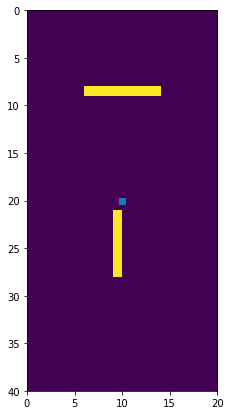

In [13]:
#Création de la pièce et du chien
# room = DogRoom('maps/mapnorm.csv')
room = DogRoom('maps/map01.csv')
dog = Dog(room, speed=1)
# human = Human(room)

showmap(room,dog)

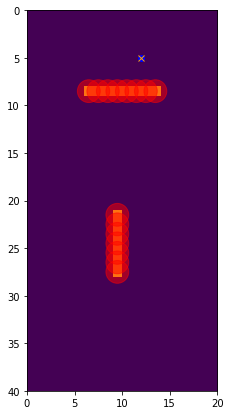

In [81]:
showpath(room, dog, obstacle, path)

In [94]:
# Crée les obstacles
obstacle_list = genObstacle(room, 1.2)

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 2
Iter: 2 , number of nodes: 3
Iter: 3 , number of nodes: 4
Iter: 4 , number of nodes: 5
Iter: 5 , number of nodes: 6
Iter: 6 , number of nodes: 7
Iter: 7 , number of nodes: 8
Iter: 8 , number of nodes: 9
Iter: 9 , number of nodes: 10
Iter: 10 , number of nodes: 11
Iter: 11 , number of nodes: 12
Iter: 12 , number of nodes: 13
Iter: 13 , number of nodes: 13
Iter: 14 , number of nodes: 14
Iter: 15 , number of nodes: 14
Iter: 16 , number of nodes: 14
Iter: 17 , number of nodes: 14
Iter: 18 , number of nodes: 15
Iter: 19 , number of nodes: 15
Iter: 20 , number of nodes: 16
Iter: 21 , number of nodes: 16
Iter: 22 , number of nodes: 16
Iter: 23 , number of nodes: 17
Iter: 24 , number of nodes: 17
Iter: 25 , number of nodes: 18
Iter: 26 , number of nodes: 18
Iter: 27 , number of nodes: 18
Iter: 28 , number of nodes: 18
Iter: 29 , number of nodes: 18
Iter: 30 , number of nodes: 18
Iter: 31 , number of nodes: 19
Iter: 32 , number of nodes:

Iter: 346 , number of nodes: 287
Iter: 347 , number of nodes: 288
Iter: 348 , number of nodes: 289
Iter: 349 , number of nodes: 290
Iter: 350 , number of nodes: 291
Iter: 351 , number of nodes: 292
Iter: 352 , number of nodes: 293
Iter: 353 , number of nodes: 294
Iter: 354 , number of nodes: 295
Iter: 355 , number of nodes: 296
Iter: 356 , number of nodes: 297
Iter: 357 , number of nodes: 298
Iter: 358 , number of nodes: 299
Iter: 359 , number of nodes: 299
Iter: 360 , number of nodes: 300
Iter: 361 , number of nodes: 301
Iter: 362 , number of nodes: 302
Iter: 363 , number of nodes: 303
Iter: 364 , number of nodes: 304
Iter: 365 , number of nodes: 304
Iter: 366 , number of nodes: 305
Iter: 367 , number of nodes: 306
Iter: 368 , number of nodes: 307
Iter: 369 , number of nodes: 308
Iter: 370 , number of nodes: 309
Iter: 371 , number of nodes: 310
Iter: 372 , number of nodes: 311
Iter: 373 , number of nodes: 312
Iter: 374 , number of nodes: 313
Iter: 375 , number of nodes: 314
Iter: 376 

Iter: 618 , number of nodes: 549
Iter: 619 , number of nodes: 550
Iter: 620 , number of nodes: 550
Iter: 621 , number of nodes: 551
Iter: 622 , number of nodes: 551
Iter: 623 , number of nodes: 552
Iter: 624 , number of nodes: 553
Iter: 625 , number of nodes: 554
Iter: 626 , number of nodes: 555
Iter: 627 , number of nodes: 556
Iter: 628 , number of nodes: 557
Iter: 629 , number of nodes: 558
Iter: 630 , number of nodes: 559
Iter: 631 , number of nodes: 560
Iter: 632 , number of nodes: 561
Iter: 633 , number of nodes: 562
Iter: 634 , number of nodes: 563
Iter: 635 , number of nodes: 564
Iter: 636 , number of nodes: 565
Iter: 637 , number of nodes: 566
Iter: 638 , number of nodes: 567
Iter: 639 , number of nodes: 568
Iter: 640 , number of nodes: 569
Iter: 641 , number of nodes: 570
Iter: 642 , number of nodes: 571
Iter: 643 , number of nodes: 572
Iter: 644 , number of nodes: 573
Iter: 645 , number of nodes: 574
Iter: 646 , number of nodes: 575
Iter: 647 , number of nodes: 576
Iter: 648 

Iter: 872 , number of nodes: 789
Iter: 873 , number of nodes: 790
Iter: 874 , number of nodes: 791
Iter: 875 , number of nodes: 792
Iter: 876 , number of nodes: 793
Iter: 877 , number of nodes: 794
Iter: 878 , number of nodes: 795
Iter: 879 , number of nodes: 796
Iter: 880 , number of nodes: 797
Iter: 881 , number of nodes: 798
Iter: 882 , number of nodes: 799
Iter: 883 , number of nodes: 800
Iter: 884 , number of nodes: 801
Iter: 885 , number of nodes: 802
Iter: 886 , number of nodes: 803
Iter: 887 , number of nodes: 804
Iter: 888 , number of nodes: 805
Iter: 889 , number of nodes: 806
Iter: 890 , number of nodes: 807
Iter: 891 , number of nodes: 808
Iter: 892 , number of nodes: 809
Iter: 893 , number of nodes: 810
Iter: 894 , number of nodes: 811
Iter: 895 , number of nodes: 812
Iter: 896 , number of nodes: 813
Iter: 897 , number of nodes: 814
Iter: 898 , number of nodes: 815
Iter: 899 , number of nodes: 816
Iter: 900 , number of nodes: 817
Iter: 901 , number of nodes: 818
Iter: 902 

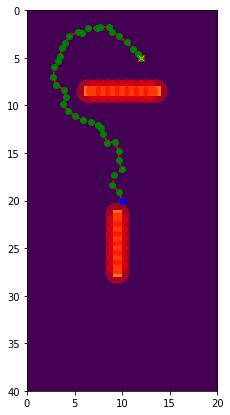

Current X: 10, Current Y: 20
Goal X: 9.658605212268084, Goal Y: 19.06008000398466
Angle absolu 109.96187487296629
Angle relatif 109.96187487296629
Distance à parcourir 0.9999999999999994
--------------
Current X: 9.63048795489182, Current Y: 19.028615740969347
Goal X: 8.972884692452558, Goal Y: 18.33221506548032
Angle absolu 133.35870495779605
Angle relatif 24.245075014014944
Distance à parcourir 0.9578183291169224
--------------
Current X: 9.002993902096007, Current Y: 18.245758997819223
Goal X: 9.187556388701452, Goal Y: 17.35552879915442
Angle absolu 78.28736926074494
Angle relatif -55.00493003451423
Distance à parcourir 0.9091606668112954
--------------
Current X: 9.216488710375284, Current Y: 17.254599566522693
Goal X: 9.97282007098549, Goal Y: 16.736367310295726
Angle absolu 34.41863321187546
Angle relatif -43.98321559871357
Distance à parcourir 0.9168433881730168
--------------
Current X: 9.96292643613863, Current Y: 16.71744367423793
Goal X: 9.660038432296195, Goal Y: 15.786542

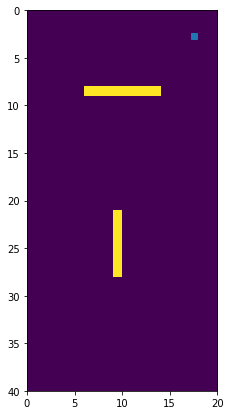

True

In [95]:
%matplotlib notebook

#définit la destination
goal = [12,5]
# goal = [140, 340]

#crée le chemin
path = generatepath(goal, obstacle_list)

#parcourt le chemin
MoveUsingPath(dog, path)

In [85]:
dog.x, dog.y

(12.0286742013746, 5.085018918860765)

In [58]:
path

[[12, 5],
 [11.389486307055273, 5.5976962666586925],
 [10.407067645360579, 5.464815474501782],
 [9.437825538862036, 5.576702666773392],
 [8.961850335340447, 5.635773520090976],
 [8.44629291768015, 5.097324496302479],
 [7.48859590179732, 4.9595090334892955],
 [6.813564343890853, 5.141194642203115],
 [6.197792904322265, 5.250969354780779],
 [5.648865675517186, 5.533082263286569],
 [4.979392458705759, 6.0826834225515665],
 [4.337590023316098, 6.513975982730487],
 [3.6409519671263464, 7.231398744195555],
 [3.1114983458392054, 7.804987083217652],
 [2.3042314496029794, 8.37277425582033],
 [2.411718090112786, 9.015315186024063],
 [3.006848151629409, 9.617714817521835],
 [3.551067515255691, 10.258219599323994],
 [4.183729155694122, 9.889599081021245],
 [4.885687856151714, 10.01372408215208],
 [5.704774907986059, 9.820576583464813],
 [6.704415082293532, 9.793752677885555],
 [7.084736574924966, 10.501126133724403],
 [6.988517122869428, 11.208844143909808],
 [7.500759762061579, 11.655191066801144

In [122]:
dog.rotate(45)

In [123]:
dog.pos()

Position: (17.553964386064887,2.701541121387619)  - Rotation: 178.58508588884484


Dimension: 40 x 20


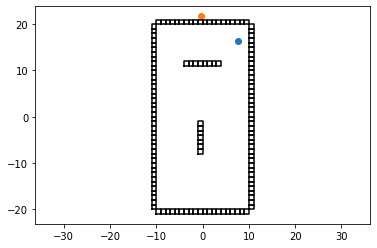

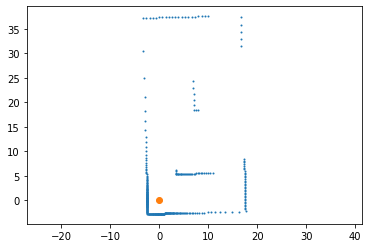

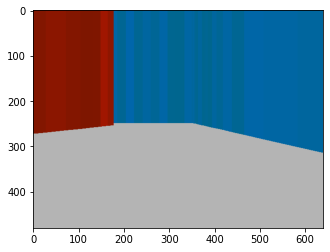

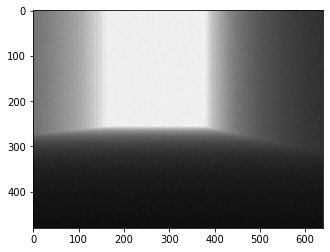

In [125]:
# POURQUOI ????
# dog.human()
dog.plotmap()
dog.plotlidar()
dog.plotRGB()
dog.plotdepth()

In [6]:
#plotting the map with imshow
def showmap(room, dog):
    dog_x, dog_y = dog.x, dog.y
    height, width = room.imgdf.shape
    # human_x, human_y = human.x, human.y

    fig,ax = plt.subplots(1,figsize=(7,7))
    fig = plt.plot(dog_x, dog_y, 's')
    # fig = plt.plot(human_x, human_y, 'x')
    
    ax.imshow(room.imgdf, origin='lower', interpolation='none', extent=(0, width, 0, height))
    plt.gca().invert_yaxis()
    plt.show()
    
# Draw final path
def showpath(room, dog, obstacle, path): 
    %matplotlib inline
    fig,ax = plt.subplots(1,figsize=(7,7))
    
    width, height = room.largeur, room.longueur

    plt.plot([x for (x, y) in path], [y for (x, y) in path], 'r--') #Plotting the path
    plt.plot([x for (x, y) in path], [y for (x, y) in path], 'o', color='green') #Plotting the path
    plt.plot(dog.x, dog.y, 'o', color='blue')
    plt.plot(goal[0],goal[1],'x', color='orange')

    for (x, y, radius) in obstacle:
        cir = plt.Circle((x, y), radius, color='r', alpha=0.5, fill=True)
        ax.add_patch(cir)
    ax.imshow(room.imgdf, origin='lower', interpolation='none', extent=(0, width, 0, height))
    plt.gca().invert_yaxis()
    plt.show()

def generatepath(goal, obstacle):
    # Set Initial parameters
    rrt_star = RRTStar(
        start=[dog.x, dog.y],
        goal=goal,
        rand_area=[-2, 15],
        obstacle_list = obstacle,
        expand_dis=1,
        max_iter=1000,
        search_until_max_iter=True)
    path = rrt_star.planning(animation=False)

    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")
        showpath(room, dog, obstacle, path)
    return path

def MoveToPoint(dog, x, y):
    
#     unit_vector_x = [1,0]
  
    #info sur le chien
    pos = np.array([dog.x, dog.y])
    curr_angle = dog.rot

    #destination
    goal = np.array([x,y])
    mov_vector = goal - pos
    
    dist = np.linalg.norm(mov_vector)

    dot = np.dot(mov_vector, [1,0])
    det = np.linalg.det(np.array([mov_vector, [1,0]])) # Vecteur x unitaire
    angle = np.degrees(np.arctan2(det, dot)) #problème d'angle hors intervalle parfois
    rot = angle - curr_angle
    
    #Debugging, 
    print("Current X: {}, Current Y: {}".format(pos[0], pos[1]))
    print("Goal X: {}, Goal Y: {}".format(x,y))
    print("Angle absolu {}".format(angle))
    print("Angle relatif {}".format(rot))
    print("Distance à parcourir {}".format(dist))
    print("--------------")
    
    #Voir si on doit ajouter qqch en fct de la speed du chien

    #fonction du simulateur
    dog.rotate(rot)
    dog.forward(dist)
    
    
#Using the path to move the dog
def MoveUsingPath(dog, path):
    keypoints = path.copy()
    keypoints.reverse()

    for x,y in keypoints[1:]:
        MoveToPoint(dog, x, y)
    showmap(room, dog)
    return True